# **MSSE Analysis**

In [1]:
import re
import pandas as pd

In [2]:
filename = 'Data/msse_courses.txt'

In [3]:
with open(filename) as f:
    lines = f.readlines()

In [4]:
# Parse that text
df = pd.DataFrame(columns=('Course Number', 'Course Title', 'Description', 'Units'))
c_num, c_title, c_describe, c_units = [],[],[],[]

i=0
for line in lines:
    m = re.match(r'(\w*\s\w?\d*\w?\s?):\s*(\w[\w: ]*[\w+]*) [\s\t]*(.*)$', line)
    if m != None:
        #print(m.group(1), m.group(2), m.group(3))
        c_num, c_title, c_describe = m.group(1), m.group(2), m.group(3)
    m = re.search(r'View Syllabus\s*(\d*)', line)
    if m != None:
        #print(m.group(1))
        c_units = m.group(1)
        print(f'{c_num}\n {c_title}\n {c_describe}\n {c_units}')
        df.loc[i] = [c_num, c_title, c_describe, c_units]
        i+=1

CHEM 280
 Foundations of Programming and Software Engineering for Molecular Sciences
 This course provides an overview of topics relevant to programming and creating software projects. The course will be taught in collaboration with members of the Molecular Sciences Software Institute (MolSII). Students will learn basic syntax, use cases, and ecosystems for Python and C++. Students will become familiar with tools and practices commonly used in software development such as version control, documentation, and testing. Central to this course is a hands-on molecular simulation project where students work in groups to create a software package using concepts taught in the course.
 2
CHEM 274A
 Programming Languages for Molecular Sciences: Python and C++
 This course provides in-depth coverage of programming concepts and techniques required for scientific computing, data science, and high-performance computing using C++ and Python. The course will compare and contrast the functionalities of 

In [5]:
display(df.iloc[3]['Course Title'])

'Principles and Techniques of Data Science'

In [6]:
df_msse = df.copy()
df_msse.head()

,Course Number,Course Title,Description,Units
0,CHEM 280,Foundations of Programming and Software Engine...,This course provides an overview of topics rel...,2
1,CHEM 274A,Programming Languages for Molecular Sciences: ...,This course provides in-depth coverage of prog...,3
2,CHEM 274B,Software Engineering Fundamentals for Molecula...,This course will advance students' understandi...,3
3,DATA 200S,Principles and Techniques of Data Science,Explores the data science lifecycle: question ...,3
4,CHEM 278,Ethics in Molecular Science and Software Engin...,This course will expose students to applied et...,1


In [7]:
# import other libs
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# create our corpus
df = pd.DataFrame(df_msse['Description'])
df['corpus']=df.Description
df['num']=df_msse['Course Number']
df.drop(columns='Description', inplace=True)

In [9]:
#nltk.download('stopwords')
stopwords.words("english")[:10] 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [10]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [11]:
df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [12]:
df.head()

,corpus,num,cleaned
0,This course provides an overview of topics rel...,CHEM 280,course provides overview topics relevant progr...
1,This course provides in-depth coverage of prog...,CHEM 274A,course provides depth coverage programming con...
2,This course will advance students' understandi...,CHEM 274B,course advance students understanding fundamen...
3,Explores the data science lifecycle: question ...,DATA 200S,explores data science lifecycle question formu...
4,This course will expose students to applied et...,CHEM 278,course expose students applied ethics professi...


In [13]:
# not much information content yet... let's drop some these terms
drop_list = 'students,techniques,course,algorithms,development,software,programming,well,covers,final,study,term'.split(',')

def preprocess_text_drop(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in drop_list]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text
'''
# Let's give our groups a chance
df['cleaned2'] = df['cleaned'].apply(lambda x: preprocess_text_drop(x, remove_stopwords=True))
df['cleaned'] = df['cleaned2'] 
df.drop(columns='cleaned2', inplace=True)
df.head()
'''

"\n# Let's give our groups a chance\ndf['cleaned2'] = df['cleaned'].apply(lambda x: preprocess_text_drop(x, remove_stopwords=True))\ndf['cleaned'] = df['cleaned2'] \ndf.drop(columns='cleaned2', inplace=True)\ndf.head()\n"

In [14]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned'])

In [15]:
# initialize kmeans with 3 centroids
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [16]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [17]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
linear,computer,programming,toolbox,oriented,covers,object,numerical,performance,libraries

Cluster 1
molecular,data,applications,professional,programming,applied,parallel,information,students,course

Cluster 2
techniques,classification,clustering,term,data,machine,regression,statistical,methods,learning

Cluster 3
provide,msse,skills,leadership,course,software,program,engineering,students,project


In [18]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [19]:
# map clusters to appropriate labels 
#cluster_map = {0: "sport", 1: "tech", 2: "religion"}
cluster_map = {}
for i in range(n_clusters):
    cluster_map[i]=f'Cluster {i}'
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

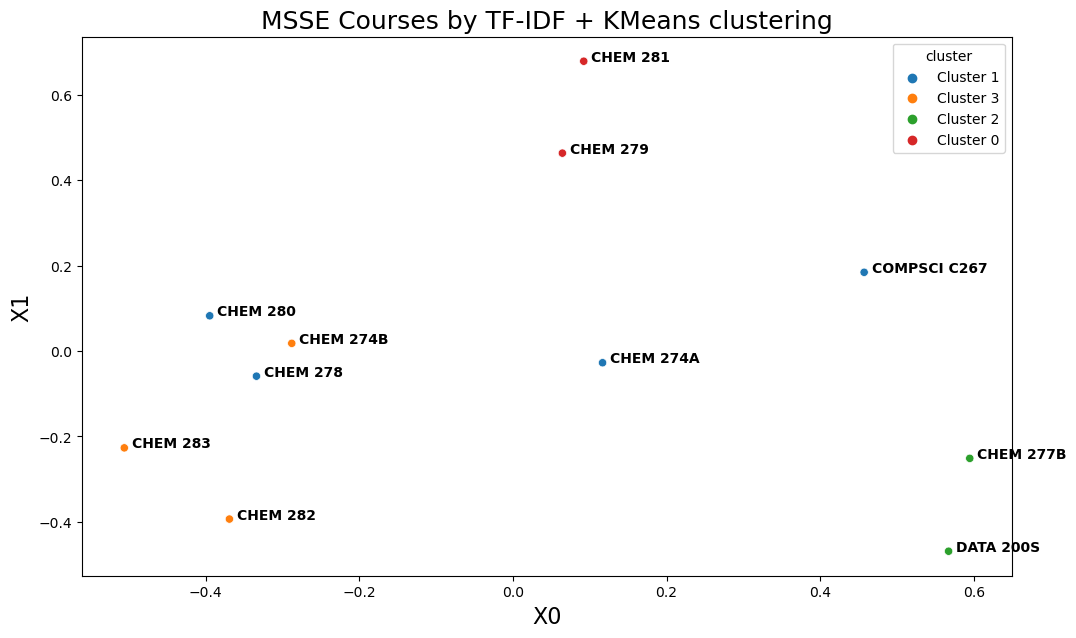

In [27]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("MSSE Courses by TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
p1=sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="tab10")

for line in range(0,df.shape[0]):
     p1.text(df.x0[line]+0.01, df.x1[line], 
     df.num[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.show()
pd.set_option('display.max_colwidth', None)

In [21]:
df_msse[df_msse['Course Number'].isin(['CHEM 282', 'CHEM 283', 'CHEM 274B '])]

,Course Number,Course Title,Description,Units
2,CHEM 274B,Software Engineering Fundamentals for Molecular Sciences,"This course will advance students' understanding of fundamental knowledge and techniques for developing complex software. Students will gain an in-depth view of computer system architecture as well as abstraction techniques as means to manage program complexity. Students will collaboratively develop a software engineering package, thus gaining experience in all aspects of the software development process from the feasibility study to the final delivery of the product. This course is a prerequisite to most MSSE courses.",3
9,CHEM 283,MSSE Capstone Project,"The main course objective is to provide MSSE students with a multifaceted experience managing a project of their choice involving the application and development of high-end computational software for Computational Sciences with an emphasis on Molecular Sciences. Students will exercise their leadership and team-building skills through individual class assignments, peer reviews, and a final Capstone project report. This course is designed to provide students with tools and practices for designing project deliverables, planning and meeting project deadlines, giving presentations, writing technical communications, and providing constructive feedback to peers. They will be supervised to complete building a professional MSSE software portfolio, which meets the best software engineering practices.",3
10,CHEM 282,Leadership Bootcamp,"This boot camp for the Master of Molecular Science and Software Engineering program is a two-week intensive course that introduces program participants to the leadership, management, and entrepreneurial skills necessary in today’s professional environment. Using the capstone project as a baseline, this course aims to provide program participants an understanding of the key aspects of management and leadership disciplines; team and organization dynamics; leading and participating in cross-functional teams; engineering economic, finance, and accounting concepts; effective communication skills, and project management.",2


In [22]:
df_msse[df_msse['Course Number'].isin(['CHEM 280', 'CHEM 278', 'CHEM 274A', 'COMPSCI C267'])]

,Course Number,Course Title,Description,Units
0,CHEM 280,Foundations of Programming and Software Engineering for Molecular Sciences,"This course provides an overview of topics relevant to programming and creating software projects. The course will be taught in collaboration with members of the Molecular Sciences Software Institute (MolSII). Students will learn basic syntax, use cases, and ecosystems for Python and C++. Students will become familiar with tools and practices commonly used in software development such as version control, documentation, and testing. Central to this course is a hands-on molecular simulation project where students work in groups to create a software package using concepts taught in the course.",2
1,CHEM 274A,Programming Languages for Molecular Sciences: Python and C++,"This course provides in-depth coverage of programming concepts and techniques required for scientific computing, data science, and high-performance computing using C++ and Python. The course will compare and contrast the functionalities of the two languages. Topics include classes, overloading, data abstraction, information hiding, encapsulation, file processing, exceptions, and low-level language features. Numerous exercises based on molecular science problems will provide the hands-on experience needed to learn these languages. This course serves as a prerequisite to later MSSE courses: Data Science, Machine Learning Algorithms, Software Engineering for Scientific Computing, Numerical Algorithms Applied to Computational Quantum Chemistry, and Applications of Parallel Computers.",3
4,CHEM 278,Ethics in Molecular Science and Software Engineering,"This course will expose students to applied ethics in professional ethics, information technology, intellectual property, and corporate ethics.",1
8,COMPSCI C267,Applications of Parallel Computers,"Models for parallel programming. Overview of parallelism in scientific applications and study of parallel algorithms for linear algebra, particles, meshes, sorting, FFT, graphs, machine learning, etc. Survey of parallel machines and machine structures. Programming shared- and distributed-memory parallel computers, GPUs, and cloud platforms. Parallel programming languages, compilers, libraries, and toolboxes. Data partitioning techniques. Techniques for synchronization and load balancing. Detailed study and algorithm/program development of medium-sized applications.",3


In [28]:
df_msse[df_msse['Course Number'].isin(['CHEM 281', 'CHEM 279'])]

,Course Number,Course Title,Description,Units
6,CHEM 281,Software Engineering for Scientific Computing,"The course covers computer architecture and software features that have the greatest impact on performance. It addresses debugging and performance tuning, detecting memory and stack overwrites, malloc corruption, hotspot, paging, and cache misses. A toolbox with common algorithms: sorting, searching, hashing, trees, and graph traversing is followed by common patterns used in object-oriented design. It describes programming paradigms, dynamic libraries, distributed architectures, and services. Lectures on linear algebra and performance libraries are provided as background for future courses. HPC paradigms and GPU programming are introduced. Software packaging, extensibility, and interactivity are followed by team development, testing, and hardening.",3
7,CHEM 279,Numerical Algorithms applied to Computational Quantum Chemistry,"An introduction to numerical algorithms, their application to computational quantum chemistry, and best practices for software implementation, and reuse. This course covers a toolbox of useful algorithms from applied mathematics that are used in physical simulations. They are illustrated via computer implementation of density functional theory for modeling chemical reaction mechanisms from quantum mechanics. Topics covered include local optimization, numerical derivatives, and numerical integration, dense linear algebra, the symmetric eigenvalue problem, the singular value decomposition, and the fast Fourier transform. More specialized topics as time permits. Students are guided through principles of procedural and object-oriented programming in C++, as well as the usage of efficient numerical libraries.",3


In [24]:
df_msse[df_msse['Course Number'].isin(['CHEM 277B', 'DATA 200S'])]

,Course Number,Course Title,Description,Units
3,DATA 200S,Principles and Techniques of Data Science,"Explores the data science lifecycle: question formulation, data collection and cleaning, exploratory, analysis, visualization, statistical inference, prediction, and decision-making. Focuses on quantitative critical thinking and key principles and techniques: languages for transforming, querying, and analyzing data; algorithms for machine learning methods: regression, classification, and clustering; principles of informative visualization; measurement error and prediction; and techniques for scalable data processing. Research term project.",3
5,CHEM 277B,Machine Learning Algorithms,"An introduction to mathematical optimization and statistics and ""nonalgorithmic"" computation using machine learning. Machine learning prerequisites are introduced including local and global optimization, various statistical and clustering models, and early metaheuristic methods such as genetic algorithms and artificial neural networks. Building on this foundation, current machine learning techniques are covered including Deep Learning networks, Convolutional neural networks, Recurrent and long short-term memory (LSTM) networks, and support vector machines and Gaussian ridge regression. Various case studies in applying optimization, statistical modeling, and machine learning methods as classification and regression tasks in different scientific software areas.",3


In [25]:
df_msse[df_msse['Course Number'].isin(['COMPSCI C267', 'CHEM 274A'])]

,Course Number,Course Title,Description,Units
1,CHEM 274A,Programming Languages for Molecular Sciences: Python and C++,"This course provides in-depth coverage of programming concepts and techniques required for scientific computing, data science, and high-performance computing using C++ and Python. The course will compare and contrast the functionalities of the two languages. Topics include classes, overloading, data abstraction, information hiding, encapsulation, file processing, exceptions, and low-level language features. Numerous exercises based on molecular science problems will provide the hands-on experience needed to learn these languages. This course serves as a prerequisite to later MSSE courses: Data Science, Machine Learning Algorithms, Software Engineering for Scientific Computing, Numerical Algorithms Applied to Computational Quantum Chemistry, and Applications of Parallel Computers.",3
8,COMPSCI C267,Applications of Parallel Computers,"Models for parallel programming. Overview of parallelism in scientific applications and study of parallel algorithms for linear algebra, particles, meshes, sorting, FFT, graphs, machine learning, etc. Survey of parallel machines and machine structures. Programming shared- and distributed-memory parallel computers, GPUs, and cloud platforms. Parallel programming languages, compilers, libraries, and toolboxes. Data partitioning techniques. Techniques for synchronization and load balancing. Detailed study and algorithm/program development of medium-sized applications.",3
